# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import shutil
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features, util

### Load data and create binary masks 

In [2]:
%%time
### CHANGE FILE/DIRECTORY NAMES
path = "/media/scholz_la/hd2/Nicolina/Raw_videos/10x_INF100"
movie = "20200326_NZ0046"
folder = "/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/0046_analyzed/"
parameterfile = "/home/nzjacic/Desktop/pharaglow_parameters_mks.txt"
lawnfile ='/media/scholz_la/hd2/Nicolina/Lawns/NZ0046_lawn.tiff'

# creating new file names
fname = os.path.join(path,movie,"*.tiff")
outfile = os.path.join(folder, movie+"_test_{}_{}.json")
print(outfile)
saveparam = os.path.join(folder, movie+"_parameters")
print(saveparam)

# starting pharaglow
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes#[:2000]
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)
    

/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/0046_analyzed/20200326_NZ0046_test_{}_{}.json
/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/0046_analyzed/20200326_NZ0046_parameters
Starting pharaglow analysis...
Loading parameters from ['Desktop', 'pharaglow_parameters_mks.txt']
open and binarize lawn file
CPU times: user 4.2 s, sys: 208 ms, total: 4.41 s
Wall time: 593 ms


### Improve lawn detection if neccessary

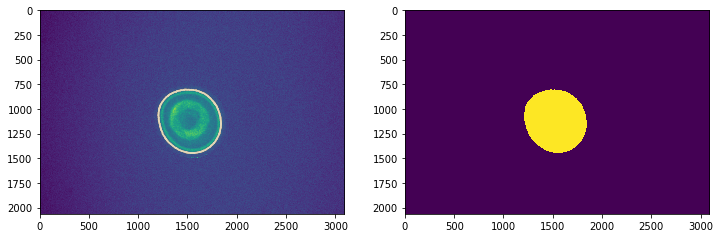

In [3]:
if lawnfile is not None:
    from skimage.filters import threshold_li, gaussian, threshold_yen, threshold_otsu
    from skimage.morphology import skeletonize, watershed, disk, remove_small_holes, remove_small_objects
    image = gaussian(lawn, 1, preserve_range = True)
    thresh = threshold_otsu(image)
    binary = image > thresh#*0.8
    binary = remove_small_holes(binary, area_threshold=15000, connectivity=1, in_place=False)
    binary = remove_small_objects(binary, min_size=50000, connectivity=8, in_place=False)
    binLawn = binary
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(lawn)
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    plt.subplot(122)
    plt.imshow(binLawn)
    

### Create binary masks

In [4]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'], dilate = param['dilate'] , tfactor=param['tfactor'])


Binarizing images
CPU times: user 2min 2s, sys: 8.77 s, total: 2min 11s
Wall time: 19.7 s


### Make sure the thesholding worked otherwise change parameters

False


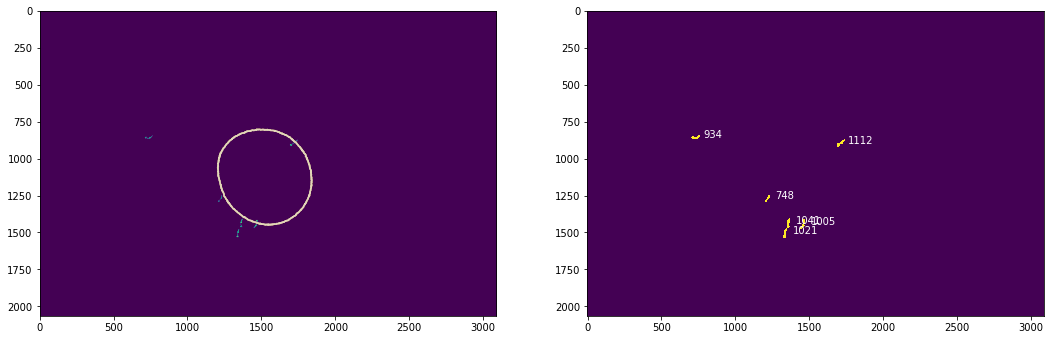

In [5]:
from skimage.measure import label, regionprops
t =7000
plt.figure(figsize=(18,16))
plt.subplot(121)
plt.imshow(rawframes[t])#+lawn)
if lawnfile is not None:
    plt.contour(binLawn, alpha=0.5, cmap='pink')
plt.subplot(122)
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
print(np.min(masks[t]))
label_image = label(masks[t], background=0, connectivity = 1)
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [6]:
%%time
import time

nWorkers = 5
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        if len(rawframes[a:b])>1:
            return tracking.runfeatureDetection(rawframes[a:b+1], masks[a:b+1], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
        #print(p, time.time()-start)
    features = pd.concat(features)
    p.close()
    p.join()

Detecting features
9001
Expected time is approx. 2227.916455162101 s
CPU times: user 3.26 s, sys: 1.13 s, total: 4.4 s
Wall time: 44min 34s


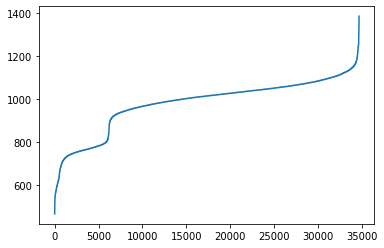

In [7]:
### Show the area of all objects
plt.plot(np.sort(features['area'].values))

### Save features

In [8]:
# # trajectories
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

# parameter file
shutil.copyfile(parameterfile, saveparam, follow_symlinks=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34705 entries, 0 to 0
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       34705 non-null  float64
 1   x       34705 non-null  float64
 2   slice   34705 non-null  object 
 3   frame   34705 non-null  int64  
 4   area    34705 non-null  int64  
 5   image   34705 non-null  object 
 6   yw      34705 non-null  float64
 7   xw      34705 non-null  float64
 8   diffI   34705 non-null  object 
 9   shapeY  34705 non-null  int64  
 10  shapeX  34705 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 12.7 MB


'/media/scholz_la/hd2/Nicolina/Pharaglow/Pharaglow_v5/0046_analyzed/20200326_NZ0046_parameters'

### Load all features

In [ ]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

### Link objects to trajectories and interpolate short misses

In [9]:
print('Done')
print('Linking trajectories')
#pred = tp.predict.NearestVelocityPredict()
#trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])
trajectories = tp.link_df(features,param['searchRange'], memory = param['memory'])

Frame 8999: 5 trajectories present.


In [10]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    # make new columns for the offset
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj, ignore_index = True)
trajectories['shapeX'] = trajectories['shapeX'].astype(int)
trajectories['shapeY'] = trajectories['shapeY'].astype(int)

Interpolating trajectories


In [11]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
print(trajectories['particle'].nunique())

10
9


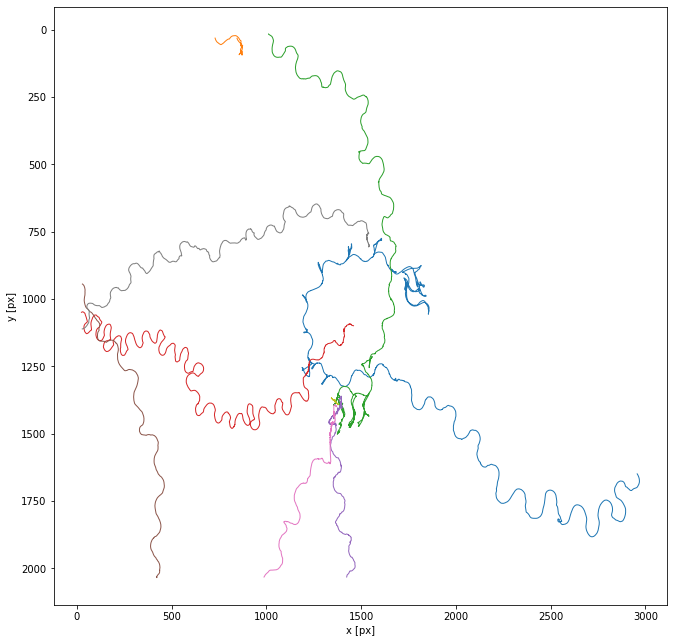

In [12]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories)#, superimpose=1-masks[8900]);

### add the missing images to interpolated trajectories

In [13]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
# interpolate the shape parameter

trajectories[['image', 'slice']] = trajectories.apply(\
       lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                               lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else pd.Series([row['image'], row['slice']]), axis=1)
trajectories[['diffI']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
                                                lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.all(np.isnan(row['diffI'])) else row['diffI'], axis=1)
# trajectories[['diffI']] = trajectories.apply(\
#         lambda row: pd.Series(tracking.fillMissingDifferenceImages(rawframes, row['frame'], row['x'], row['y'],\
#                                                 lengthX=row['shapeX'],lengthY=row['shapeY'], size=param['watershed'])) if np.sum((row['diffI']))==0 else row['diffI'], axis=1)

Fill in missing images
CPU times: user 15 s, sys: 4.88 s, total: 19.9 s
Wall time: 20.1 s


### Extract lawn info

In [14]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

CPU times: user 5.73 s, sys: 27.2 ms, total: 5.76 s
Wall time: 5.76 s


### Show resulting trajectories

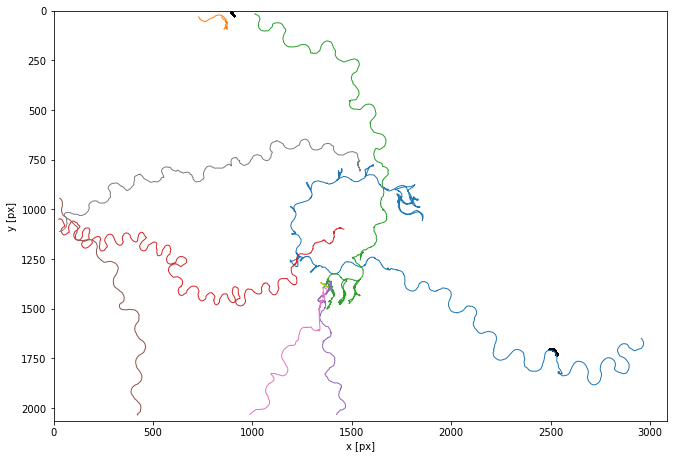

In [18]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[500]);

In [16]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')

### check slow-down before continuing analysis

t0: 1413
pid: 0.0
t0: 1446
pid: 3.0
t0: 4033
pid: 4.0
t0: 3218
pid: 5.0
t0-dt or t0+dt exceeds number of frames
t0: 3046
pid: 8.0
t0-dt or t0+dt exceeds number of frames
t0: 0
trajectory is too short


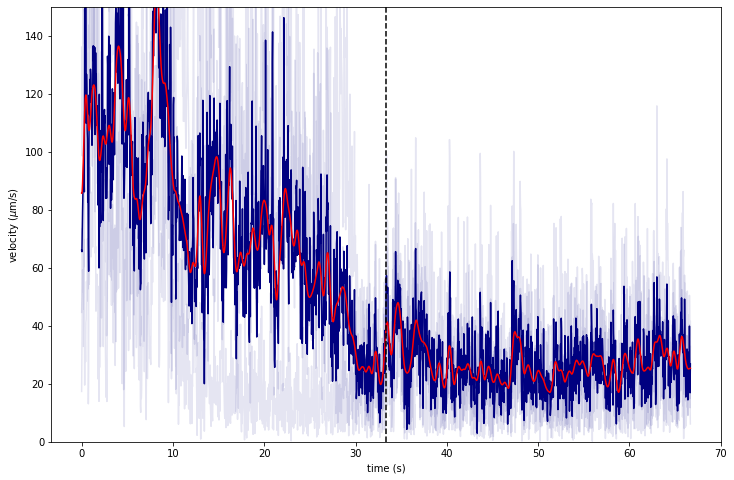

In [17]:
if lawnfile is not None:
    plt.figure(figsize=(12,8))
    vcut = []
    dt = 1000
    for pid in trajectories['particle'].unique():
        tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
        f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
        if f<0.9 and f>0.01:
            t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
            print('t0:', t0)
            try:
                if t0>dt:
                    print('pid:', pid)
                    time = np.linspace(0,2*dt/30., 2*dt)
                    #print('time:', len(time))
                    v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
                    #print('v:', v)
                    #print('v.iloc:', v.iloc[t0-dt:t0+dt])
                    plt.plot(time, v.iloc[t0-dt:t0+dt], 'navy', alpha=0.1)
                    vcut.append(v.iloc[t0-dt:t0+dt].values)
                else:
                    print('trajectory is too short')
            except ValueError:
                print('t0-dt or t0+dt exceeds number of frames')
                continue
                    
    plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
    plt.plot(time, util.smooth(np.mean(np.array(vcut), axis=0), 30), color='r')
    plt.axvline(dt/30, color='k', linestyle='--')
    plt.ylabel(r"velocity ($\mu$m/s)");
    plt.xlabel("time (s)");
    plt.ylim(0,150)


### run the whole pharaglow feature extraction

In [19]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

#### run this if acidentally used an odd length like an idiot.

In [20]:
def padIm(im, size = 22500):
    return np.pad(im, (0,size-len(im)), mode='constant', constant_values=0)

def fixImages(trajectories):
    trajectories[['image']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['image'], row['shapeX']*row['shapeY'])) if len(row['image'])<row['shapeX']*row['shapeY'] else row['image'], axis=1)
    trajectories[['diffI']] = trajectories.apply(\
       lambda row: pd.Series(padIm(row['diffI'], row['shapeX']*row['shapeY'])) if len(row['diffI'])<row['shapeX']*row['shapeY'] else row['diffI'], axis=1)


### Save data as json format (every trajectory in a file)

In [ ]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file = os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  pd.read_json(file, orient='split', numpy = True)
        traj['shapeX'] = traj['shapeX'].astype(int)
        print('Analyzing trajectory:', fn)
        # interpolate if images are not the right size:
        fixImages(traj)
        #tmp = run.runPharaglowOnStack(traj, param)
        tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = 10, params = param)
        # get more exact entry location
        if lawnfile is not None:
            tmp['insideHead'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], binLawn)), axis=1)
            tmp['insideHeadIntensity'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], lawn)), axis=1)
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  import sys


Analyzing trajectory: 20200326_NZ0046_test_trajectories_0.json
[900, 900, 900, 900, 900, 900, 900, 900, 900, 899]


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/si

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 143 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 193 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 121 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 157 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 174 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 173 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 149 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 159 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 150 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 212 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 135 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 122 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 134 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 127 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

Analyzing trajectory: 20200326_NZ0046_test_trajectories_1.json
[27, 27, 26, 26, 26, 26, 26, 26, 26, 26]


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/si

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/p

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 165 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 177 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 172 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

Analyzing trajectory: 20200326_NZ0046_test_trajectories_3.json
[827, 827, 827, 827, 827, 827, 827, 827, 827, 826]


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/filters/thresholding.py:638: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/filters/thresholding.py:638: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/nzjacic/.conda/envs/pumping/lib/python3.

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/nzjacic/.conda/envs/p

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 175 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 170 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/p

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 156 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 136 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 182 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 152 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 141 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 158 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 129 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 168 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 164 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 154 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 155 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 151 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 167 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 153 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 147 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 140 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 137 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 146 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 161 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 131 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 138 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 120 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 130 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 192 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 125 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use

/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 133 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 148 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 144 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 142 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/skimage/util/dtype.py:503: Use